In [27]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import math
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from crp.image import imgify, vis_opaque_img, plot_grid
from torch.optim import SGD, Adam

import copy

In [28]:
from expbasics.leemann import disjoint_orthogonality_loss, nearest_neighbors, vis_nearest_neighbors
from expbasics.helper import get_attribution_function, get_model_etc
from expbasics.network import train_network, accuracy_per_class, load_model
from expbasics.biased_noisy_dataset import BiasedNoisyDataset, get_biased_loader
from expbasics.ground_truth_measures import GroundTruthMeasures
from expbasics.crp_attribution import CRPAttribution
from expbasics.visualizations import plot_nmfs

%reload_ext autoreload
%autoreload 2

In [22]:
l = list(
    np.round(np.linspace(0.5, 1, 26), 3)
) 
print(len(l), l, len(l)*6)

26 [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0] 156


8


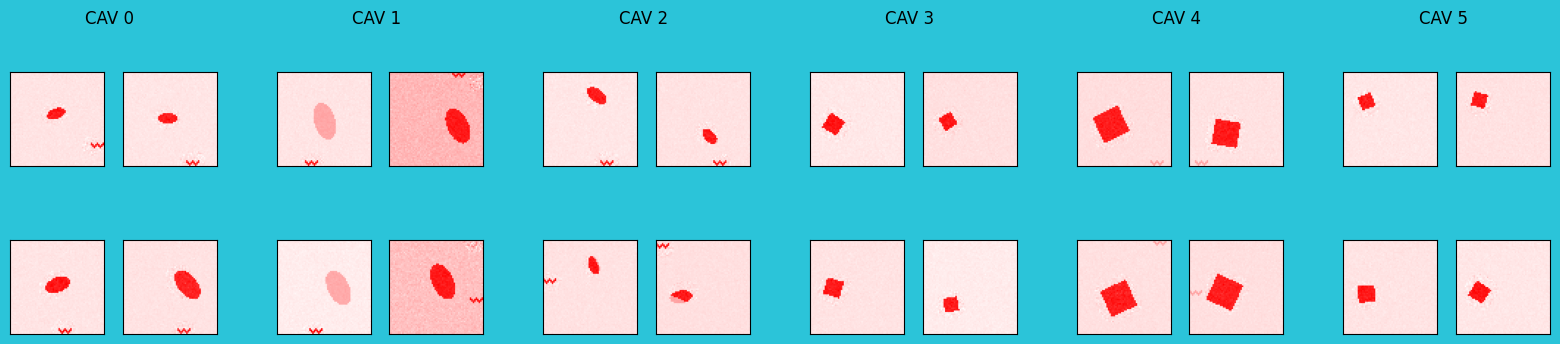

In [43]:
BIAS = 0.95
NUM_IT = 2
BATCH_SIZE = 128
N_BASIS = 2
BATCH_STEP_SIZE = 256
NUM_NEIGHBORS = 36
SPATIAL_STEPSIZE = 1

MAX_INDEX = 3000
STRENGTH = 0.5
LR = 0.001

LAYER_NAME = "linear_layers.0"  # "convolutional_layers.6" #
N_NEURONS = 6
NEURONS = range(N_NEURONS)  # 8

model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(
    BIAS, num_it=NUM_IT
)

# dataset = BiasedNoisyDataset(BIAS, STRENGTH, True)
# res = accuracy_per_class(model, test_loader)
# crp_attribution.make_all_relevances(LAYER_NAME,NEURONS )

# manually trying out other stuff
no_ref_samples = 8
all_refs = {}


def vis_simple(
    data_batch, heatmaps, rf=False, alpha=1.0, vis_th=0.0, crop_th=0.0, kernel_size=9
):
    return vis_opaque_img(
        data_batch, heatmaps, rf=rf, alpha=0.0, vis_th=0.0, crop_th=0.5
    )


ref_c = crp_attribution.fv.get_max_reference(
    list(NEURONS),
    LAYER_NAME,
    "relevance",
    (0, no_ref_samples),
    composite=crp_attribution.composite,
    #rf=True,
    plot_fn=vis_opaque_img,
)
print(len(ref_c[0]))
# all_refs = {i:ref_c[i] for i in range(8)}
cav_c = torch.zeros((N_NEURONS, no_ref_samples, 64, 64))

for n in ref_c.keys():
    for i in range(len(ref_c[n])):
        cav_c[n,i] = torch.tensor(np.array(ref_c[n][i]))
        

plot_nmfs(cav_c, no_ref_samples, N_NEURONS)

In [33]:
rbias = 0.9
rnumit = 6
NAME = "../clustermodels/noise_pos"
train_loader = get_biased_loader(rbias, 0.5, batch_size=128, verbose=False)
model = train_network(
    train_loader,
    rbias,
    0.5,
    NAME,
    BATCH_SIZE,
    load=True,
    retrain=False,
    learning_rate=0.001,
    epochs=3,
    num_it=rnumit,
)
model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(
    rbias, num_it=rnumit
)

making new test dataset


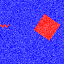

In [40]:
img = unbiased_ds[1293][0]

imgify(img)

output: tensor([[ 9.3828, -9.2569]]), 
 latents: [ 0  1 39  7  8], watermark: False, prediction:0 
 convolutional_layers.0: 
 0: 0.11, 1: -0.19, 2: -0.0, 3: 0.12, 4: -0.12, 5: 0.13, 6: -0.09, 7: -0.24 
 convolutional_layers.3: 
 0: 0.12, 1: -0.1, 2: -0.17, 3: -0.23, 4: -0.09, 5: 0.02, 6: -0.12, 7: -0.15 
 convolutional_layers.6: 
 0: 0.06, 1: 0.08, 2: -0.1, 3: 0.11, 4: 0.03, 5: 0.33, 6: 0.03, 7: 0.25 
 linear_layers.0: 
 0: 0.23, 1: -0.04, 2: 0.28, 3: -0.08, 4: 0.28, 5: -0.09 
 linear_layers.2: 
 0: 0.5, 1: -0.5 


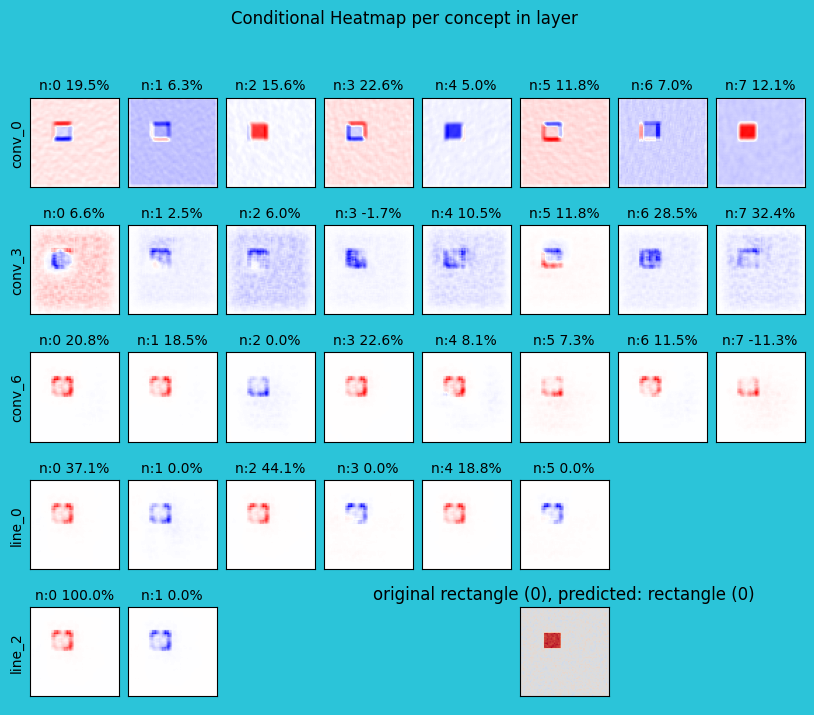

In [74]:
import json
FV_NAME = "noise_pos"
index =  np.random.randint(0, MAX_INDEX)#MAX_INDEX # 2984 # 341052
img, target = unbiased_ds[index]
#index = wrong_idx[2]
latents, wm, offset = unbiased_ds.get_item_info(index)
rel = crp_attribution.image_info(index, verbose=True)

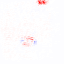

In [69]:
from zennit.composites import EpsilonGammaBox
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.attribution import Gradient

img = img.view(1,1,64,64)
#img.requires_grad = True
canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonGammaBox(low=-3., high=3., canonizers=canonizers)
with Gradient(model=model, composite=composite) as attributor:
    out, relevance = attributor(img, torch.eye(2)[[0]])

max_rel = relevance.abs().max()    

imgify(relevance[0,0], vmin=-max_rel, vmax=max_rel)

tensor([-2.6585e-03, -2.6769e-03,  2.8372e-03, -1.7453e-03, -5.6178e-03,
         5.1837e-03, -1.2958e-03,  9.9647e-05,  1.0469e-01, -1.8250e-01,
        -2.0889e-02,  1.1355e-01, -9.7708e-02,  1.2184e-01, -8.3309e-02,
        -2.5339e-01,  7.8200e-04,  3.0775e-03, -4.7430e-03, -1.0163e-02,
        -1.9861e-03,  1.2436e-02, -2.7295e-03, -2.4711e-03,  1.2133e-01,
        -9.2899e-02, -1.7929e-01, -1.9962e-01, -8.4103e-02,  2.2714e-02,
        -1.0519e-01, -1.5647e-01, -7.4294e-03, -7.2634e-03, -4.1368e-03,
        -2.4867e-03, -3.1123e-03,  1.5625e-02, -9.9587e-03,  6.4687e-02,
        -7.1476e-02, -6.5518e-02, -8.0444e-02, -4.8533e-02, -4.8670e-02,
         2.5996e-01, -6.5871e-02,  2.4483e-01, -6.9582e-02, -4.9550e-03,
        -7.5795e-02,  1.0801e-01, -5.4758e-02,  1.0426e-01,  1.8218e-02,
        -3.9755e-02,  2.0958e-02,  2.3231e-01,  2.6332e-02,  2.4506e-01,
        -1.3854e-01,  1.7042e-01, -3.0534e-01,  3.8570e-01])


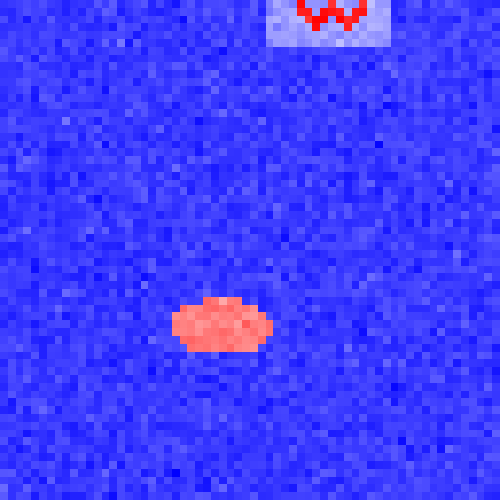

In [68]:
res = crp_attribution.watermark_importance(index)
image = copy.deepcopy(img[0])
maskedi = image + 0.3* res["mask"]
print(res["relevances"])
imgify(
    maskedi,
    resize=500,
)

{'linear_layers.2_1': {'linear_layers.0_5': 0.43708252906799316, 'linear_layers.0_3': 0.3284390866756439, 'linear_layers.0_2': -0.034682441502809525, 'linear_layers.0_0': -0.09372258931398392, 'linear_layers.0_4': -0.10607334971427917}, 'linear_layers.0_5': {'convolutional_layers.6_5': 0.06888615588347118, 'convolutional_layers.6_7': 0.06540237367153168}, 'linear_layers.0_3': {'convolutional_layers.6_5': 0.07632888853549957, 'convolutional_layers.6_7': 0.06139030555884043}, 'linear_layers.0_1': {}, 'linear_layers.0_2': {'convolutional_layers.6_7': 0.05248049398263296}, 'linear_layers.0_0': {'convolutional_layers.6_7': 0.04649820923805237}, 'linear_layers.0_4': {'convolutional_layers.6_7': 0.04488412539164225}, 'convolutional_layers.6_5': {'convolutional_layers.3_6': 0.07682592272758484, 'convolutional_layers.3_0': 0.0751417338848114}, 'convolutional_layers.6_7': {'convolutional_layers.3_0': 0.12014526128768921, 'convolutional_layers.3_5': 0.05080960392951965}, 'convolutional_layers.6_0

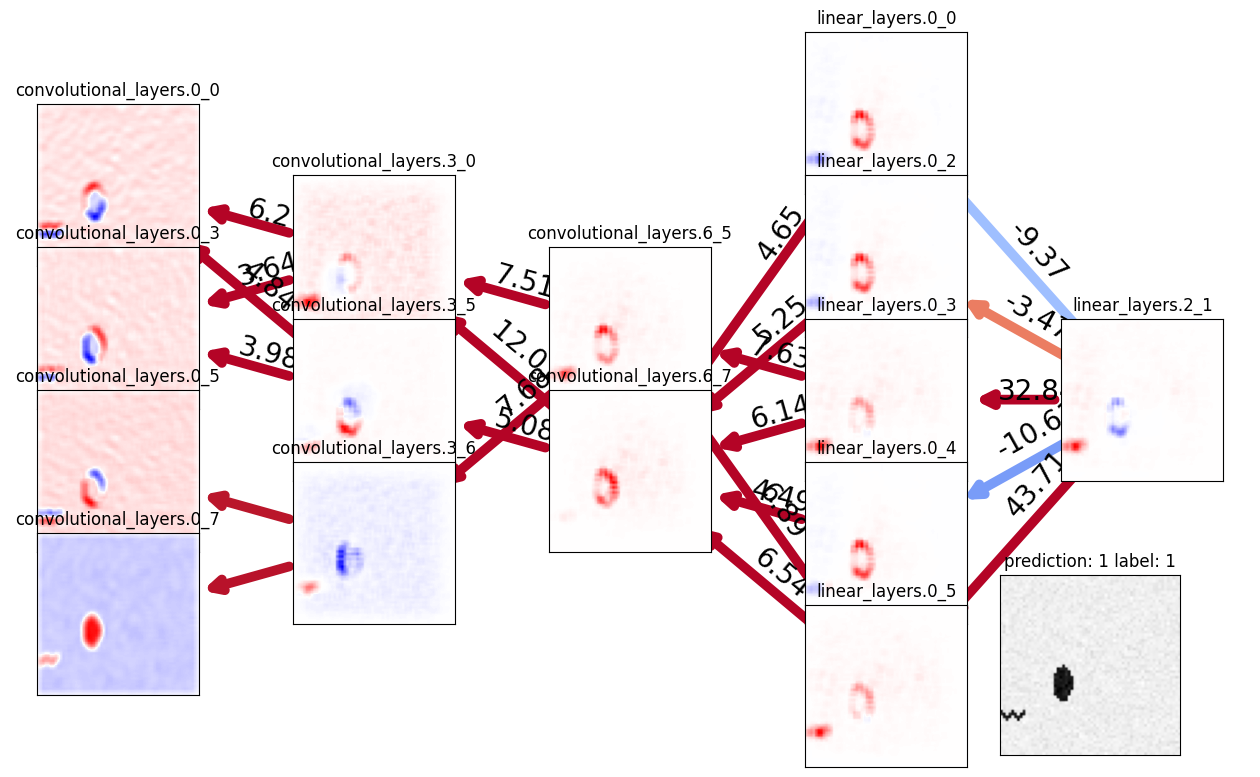

In [42]:
from expbasics.plotting import draw_graph_with_images
#index = wrong_idx[9]
node_labels, edges, images = crp_attribution.complete_relevance_graph(index)
#edges
draw_graph_with_images(node_labels, edges, images)

In [45]:
allwm = get_biased_loader(
    0.0, 0.0, batch_size=128, verbose=False, split=0.5, 
)
nowm = get_biased_loader(
    0.0, 1.0, batch_size=128, verbose=False, split=0.5, 
)

all_wm_accuracy = list(accuracy_per_class(model, allwm, False))
no_wm_accuracy = list(accuracy_per_class(model, nowm, False))
all_wm_accuracy, no_wm_accuracy

100%|██████████| 1920/1920 [02:35<00:00, 12.35it/s]


([99.66828998609745, 99.12512931631382, 99.39697265625],
 [99.68612527342067, 99.2270791083311, 99.456787109375])

In [43]:
model.eval()
wrong = []
wrong_idx = []
STEP_SIZE = 1
idx = np.array(list(range(0, MAX_INDEX, STEP_SIZE)))
with torch.no_grad():
    for count, index in enumerate(idx):
        x, target = unbiased_ds[index]
        output = model(x.view(1, 1, 64, 64))
        preds = output.data.max(dim=1)[1]
        if target != preds:
            if preds == 1:
                wrong += [np.linalg.norm(output.data[0] - torch.Tensor([1,0]))]
            else:
                wrong += [np.linalg.norm(output.data[0] - torch.Tensor([0,1]))]
            wrong_idx.append(index)
wrong = np.array(wrong)
wrong_idx = np.array(wrong_idx)
inds = np.argsort(1/wrong)
wrong = wrong[inds]
wrong_idx = wrong_idx[inds]
len(wrong)

6

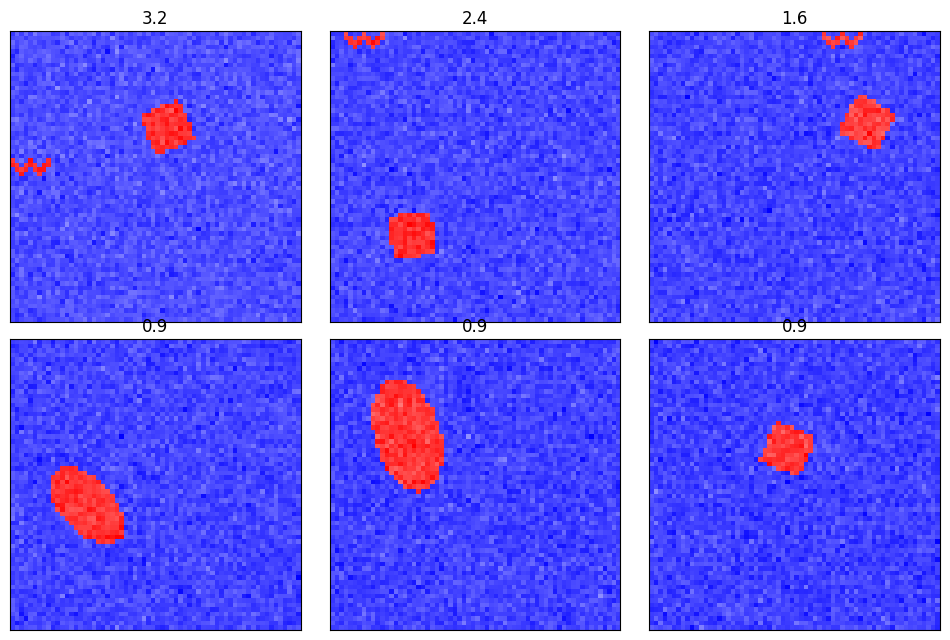

In [46]:
amt = min(len(wrong_idx), 32)

modulo = 3
f, ax = plt.subplots(
    (amt// modulo) ,modulo,  figsize=(12, 8), gridspec_kw={"wspace": 0.1, "hspace": 0}
)
for n in range(amt):
    ax[n // modulo, n%modulo].xaxis.set_visible(False)
    ax[n // modulo, n%modulo].yaxis.set_visible(False)

    if n < amt:
        ax[n // modulo, n%modulo].set_title(round(wrong[n],1))
        ax[n // modulo, n%modulo].imshow(imgify(unbiased_ds[wrong_idx[n]][0][0]))

In [27]:
MAX_INDEX = 491520
STEP_SIZE = 1000
single_attr = get_attribution_function(model, heatmap=False, batch_size=1)
# cavs_loader = DataLoader(unbiased_ds, batch_size=BATCH_SIZE, shuffle=False)

idx = np.array(list(range(0, MAX_INDEX, STEP_SIZE)))
cavs = torch.zeros((len(idx), 6))
for count, index in enumerate(idx):
    x, _ = unbiased_ds[index]
    res = single_attr(x).detach().contiguous()
    cavs[count] = res

tensor([0., 0., 0., 0., 0., 0.])


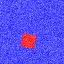

In [28]:
randi = np.random.randint(0, len(idx))
print(cavs[randi])
imgify(unbiased_ds[idx[randi]][0])

In [29]:
loss_fn = lambda x: disjoint_orthogonality_loss(
    x, normalize=True, disjoint=True, losstype="offdiagl2"
)
attribution_fn = get_attribution_function(model, heatmap=False)


def train_loop(
    model, attribution_fn, loss_fn, n_iter=100, ground_truth_dirs=None, optimize=True
):
    """Main look to recover the matrix M such that the directions fulfill the IMA/DMA criterion.
    Parameters:
        args: Command line arguments
        model: The trained encoder.
        A_init: Intial matrix M at the start of the optimization
        attribution_fn: Function to compute the gradients. Can be used to implement variations
            of the gradient such as integrated or smoothed grad.
        loss_fn: Function that computes the loss
        logger: Custom logger object to log the optimization progress
        n_iter: Number of iterations to perform
        ground_truth_dirs: Ground truth directions if known (required to compute some alignment metrics)
        optimize: True, if A should be optimized, otherwise only the loss and the metrics are computed and logged.
    Returns the matrix with the discovered directions and the average loss
    """
    A_init = torch.randn(2, 6) #eye
    if optimize:
        A = A_init.clone()
        A.requires_grad_(True)

        opt = Adam((A,), lr=LR)
    else:
        A = A_init

    running_loss = 0.0
    cum_loss = 0.0
    with tqdm(total=n_iter, position=0, leave=True) as pbar:
        epoch_sz = len(test_loader)
        for epoch in range(n_iter // epoch_sz + 1):
            for i, data in enumerate(test_loader):
                x, _ = data
                J = attribution_fn(x).detach().contiguous()
                #J = J[:,[1,3,4]]
                J = J.view(J.size(0), J.size(1), -1)  # [B, latent_dim, input_dim]
                disentangledJ = torch.matmul(A.unsqueeze(0), J) #A.unsqueeze(0)
                disentangledJ = disentangledJ.reshape(J.size(0), A.size(0))
                loss = torch.mean(loss_fn(disentangledJ)[1])
                if optimize:
                    loss.backward()
                    opt.step()
                running_loss += loss.detach().item()
                cum_loss += loss.detach().item()
                pbar.update(1)
                if epoch * epoch_sz + i >= n_iter:
                    print("over")
                    break
    return A.detach(), cum_loss / n_iter

H, loss = train_loop(model, attribution_fn, loss_fn)
H, loss

  0%|          | 0/100 [00:00<?, ?it/s]

101it [00:59,  1.70it/s]                         

over


(tensor([[nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan]]),
 nan)

In [117]:
nn_idx = nearest_neighbors(H, cavs, idx, NUM_NEIGHBORS, "cosine")  # , "cosine"
for i in range(N_BASIS):
    vis_nearest_neighbors(unbiased_ds, nn_idx[i], f"{LAYER_NAME}_cosine_{i}")

/home/lilli/Desktop/MASTER/code/experiments/expbasics/leemann.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H = torch.tensor(H, dtype=torch.float32)


In [118]:
from torch.autograd import grad

crpattr = get_attribution_function(model)

def input_jacobian(net, x):
    """Compute jacobians w.r.t. input. This function is similar to torch.autograd.functional.jacobian
    in later pytorch versions.
    Parameters:
        net: Encoder for which encode_deterministic will be called.
    Return the gradient with respect to each input for each sample.
    """
    x.requires_grad_(True)
    out = net(x)
    J_list = []
    for k in range(net.z_dim):
        J = grad(out[:, k], x, torch.ones_like(out[:, k]), retain_graph=True)[0]
        # print(J.shape)
        J_list.append(J)
    jac = torch.stack(J_list, dim=1)
    return jac


def smoothgrad_gradients(net, x, n_samples=20, noise_lvl=0.02):
    """Return the smoothgrad attributions."""
    noise = noise_lvl * torch.randn(n_samples, *x.shape)
    interps = x.reshape(-1, x.size(0), x.size(1), x.size(2), x.size(3)) + noise
    interps = interps.contiguous()
    old_shape = interps.shape
    # print(interps.shape)
    # flatten inputs to compute model gradients.
    interps = interps.reshape(-1, interps.size(2), interps.size(3), interps.size(4))

    jacs = input_jacobian(net, interps)
    # print(jacs.shape)
    sg = jacs.reshape(
        old_shape[0], old_shape[1], -1, old_shape[2], old_shape[3], old_shape[4]
    ).sum(dim=0)
    return sg

attribution_fn = lambda net, x: smoothgrad_gradients(
    net, x, n_samples=128
)  # get_attribution_function(model)

In [119]:
cond_layer = "linear_layers.0" #"convolutional_layers.6"  # 

t = torch.zeros((N_BASIS, NUM_NEIGHBORS, 64, 64))
told = torch.zeros((N_BASIS, NUM_NEIGHBORS, 64, 64))
for i in range(N_BASIS):
    for index in range(NUM_NEIGHBORS):
        hold = crp_attribution.heatmap(nn_idx[i][index])
        h = crp_attribution.cav_heatmap(nn_idx[i][index], cond_layer, H[i])
        t[i][index] = h
        told[i][index] = hold


def show_neighbors(hms, index):
    return imgify(
        hms[index],
        grid=(
            math.floor(math.sqrt(NUM_NEIGHBORS)),
            math.floor(math.sqrt(NUM_NEIGHBORS)),
        ),
        symmetric =True
    )


def show_all_cavs(hms):
    f, ax = plt.subplots(
        1, N_BASIS, figsize=(20, 12), gridspec_kw={"wspace": 0.1, "hspace": 0}
    )
    for n in range(N_BASIS):
        ax[n].xaxis.set_visible(False)
        ax[n].yaxis.set_visible(False)
        ax[n].imshow(show_neighbors(hms, n))

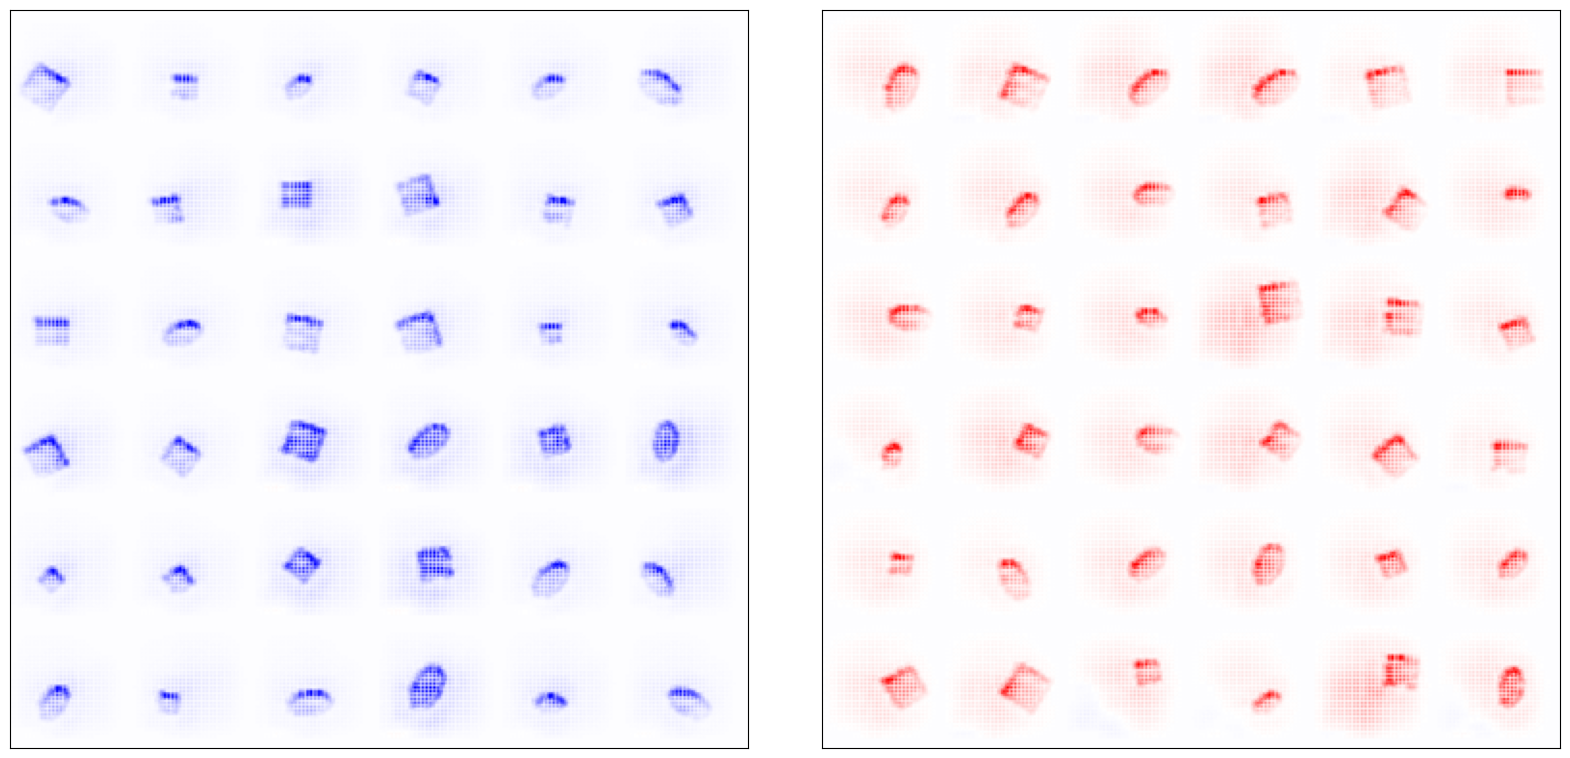

In [120]:
show_all_cavs(t)

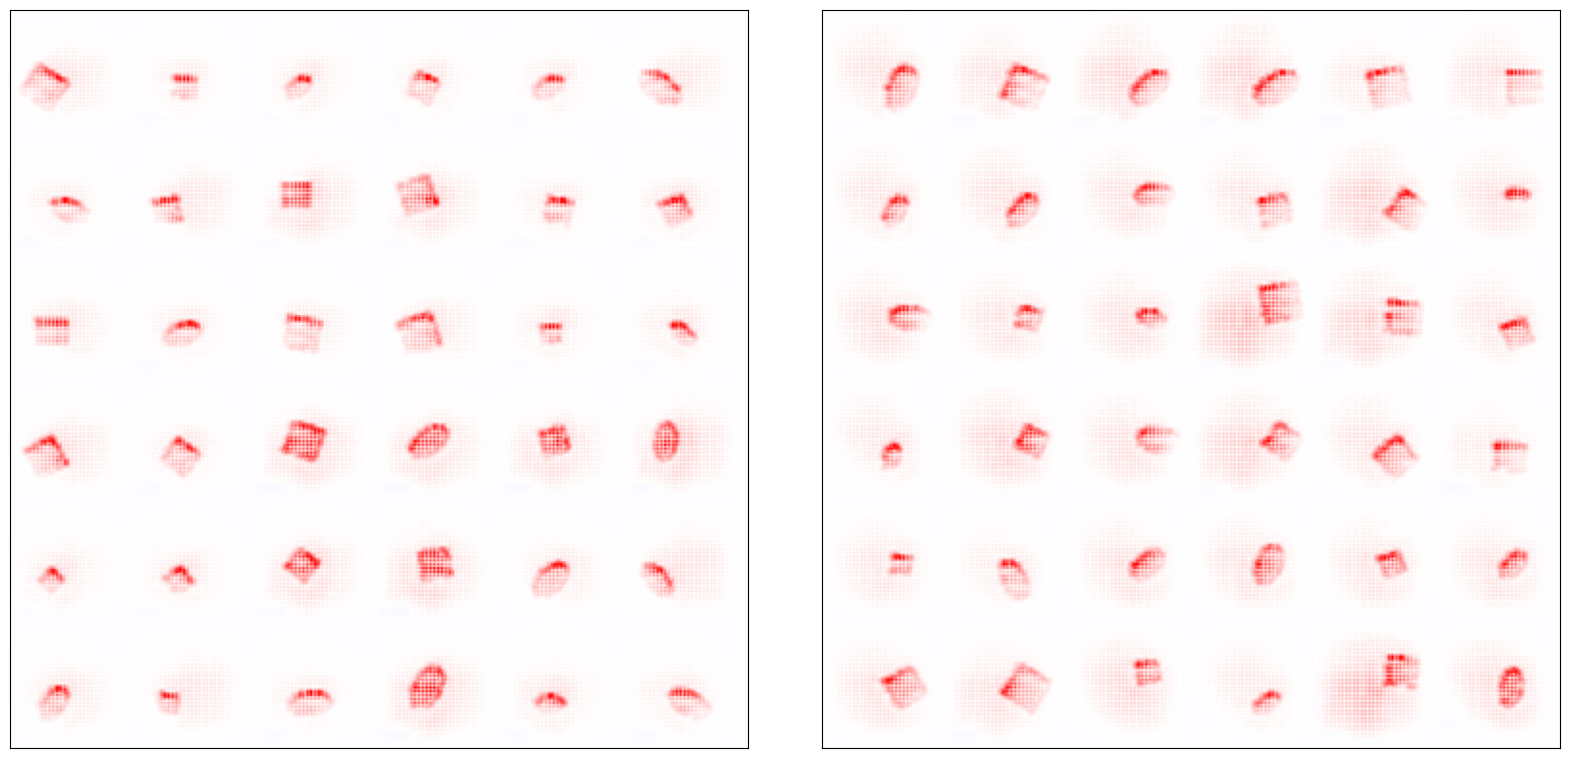

In [121]:
show_all_cavs(told)

In [48]:
H,  [np.intersect1d(nn_idx[x], nn_idx[y]).shape if x != y else "same" for x in range(4) for y in range(4)]


(array([[ 0.        ,  0.        , 11.75612329,  8.71191297, 22.50457525,
          0.        ],
        [ 0.        ,  0.        ,  0.02257934,  0.        ,  0.02345084,
         12.35677329],
        [ 0.        ,  0.        ,  3.80525514,  2.85483271,  4.24792524,
          0.        ],
        [ 0.        ,  0.        ,  4.30456958,  2.68263138,  5.69847257,
          0.        ]]),
 ['same',
  (0,),
  (0,),
  (0,),
  (0,),
  'same',
  (0,),
  (0,),
  (0,),
  (0,),
  'same',
  (0,),
  (0,),
  (0,),
  (0,),
  'same'])

In [1]:
L1  https://transformer-circuits.pub/2023/monosemantic-features

TCAV -> 

multipliziere activations in latent space mit basisvektoren 
https://arxiv.org/abs/2303.12641

SyntaxError: invalid syntax (911830306.py, line 1)